## Implementing GPT model from scratch to generate text

### 1) Coding an LLM architecture

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 200019,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.size()
        tok_embeds = self.token_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        

    def forward(self, x):
        return x

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("o200k_base")

batch = []

txt1 = "Pierwszy dzień wiosny jest"
txt2 = "Kazdy dzień jest bardzo dobry na"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)
#check num of tokens in tokenizer
print(tokenizer.n_vocab)

tensor([[152687,   8811,   3705, 155653,    286,   2453,   3008,  12637],
        [197105,   7593, 155653,  12637,  49755,  25148,   1102,    898]])
200019


In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 8, 200019])
tensor([[[-7.9670e-01, -1.5191e+00, -2.3169e+00,  ...,  1.8177e-01,
           7.0826e-01, -4.7331e-01],
         [ 6.9835e-01,  6.0731e-01,  3.3680e-01,  ...,  1.7759e+00,
          -5.1157e-01, -6.6683e-01],
         [-2.8688e-01, -7.9203e-01,  3.5718e-02,  ...,  1.1765e+00,
           7.8765e-01, -2.7011e-01],
         ...,
         [-1.1749e+00, -1.0568e+00,  8.8069e-01,  ...,  2.0276e-01,
           9.7955e-01,  6.6893e-01],
         [-1.0532e+00,  1.8222e-01,  2.5785e-01,  ..., -3.7386e+00,
          -1.0138e+00, -1.7017e+00],
         [ 5.6126e-01,  4.8769e-01, -8.2236e-01,  ...,  3.1312e-02,
          -4.7627e-01, -3.1223e-01]],

        [[-2.2843e-01, -4.6201e-01, -1.6914e+00,  ...,  1.1486e+00,
          -3.3998e-01, -4.6595e-02],
         [ 1.0330e-01,  2.3047e-01, -1.7211e-01,  ...,  1.0148e-01,
          -1.2830e+00, -9.1505e-02],
         [ 3.5997e-01, -2.3105e+00, -1.6541e-01,  ...,  1.3573e+00,
           6.0159e-01, -6.1696e-01]

### 2) Normalizing activations with layer normalization

In [5]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [6]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [7]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [8]:
ln = LayerNorm(6)
outputs_normed = ln(out)
outputs_normed

tensor([[ 0.6745,  1.5470, -0.9549,  0.6431, -0.9549, -0.9549],
        [-0.0207,  0.1228, -1.1913,  1.6619,  0.6186, -1.1913]],
       grad_fn=<AddBackward0>)

In [9]:
outputs_normed.mean(dim=-1, keepdim=True), outputs_normed.var(dim=-1, keepdim=True)

(tensor([[ 0.0000e+00],
         [-1.9868e-08]], grad_fn=<MeanBackward1>),
 tensor([[1.1994],
         [1.1996]], grad_fn=<VarBackward0>))

### 3) Implementing a feed forward network with GELU activation

In [10]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

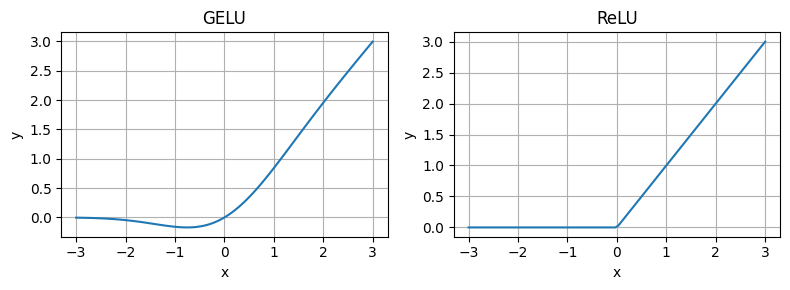

In [11]:
import matplotlib.pyplot as plt
import numpy as np

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x.numpy(), y.numpy())
    plt.title(label)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
ffn = FeedForward(GPT_CONFIG_124M)

In [14]:
x = torch.rand(2, 3, 768)
ffn(x).shape

torch.Size([2, 3, 768])

In [15]:
ffn.layers[0].weight

Parameter containing:
tensor([[-0.0223,  0.0308,  0.0022,  ..., -0.0174, -0.0227, -0.0178],
        [-0.0027, -0.0043, -0.0274,  ...,  0.0079,  0.0112,  0.0010],
        [-0.0029,  0.0175,  0.0244,  ..., -0.0164, -0.0300,  0.0045],
        ...,
        [ 0.0255,  0.0023,  0.0277,  ..., -0.0037, -0.0134, -0.0284],
        [ 0.0266,  0.0236, -0.0193,  ...,  0.0120,  0.0061, -0.0261],
        [ 0.0222,  0.0106, -0.0190,  ..., -0.0253,  0.0320, -0.0109]],
       requires_grad=True)

### 4) Adding shortcut connections

In [16]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1], GELU())),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2], GELU())),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3], GELU())),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4], GELU())),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5], GELU()))
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x
    
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")  

    

In [17]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

In [18]:
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes=layer_sizes,
    use_shortcut=True
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.2261722832918167
layers.1.0.weight has gradient mean of 0.5056600570678711
layers.2.0.weight has gradient mean of 0.30353114008903503
layers.3.0.weight has gradient mean of 0.454271525144577
layers.4.0.weight has gradient mean of 0.971720278263092


### 5) Connecting attention and linear layers in a transformer block

In [21]:
from utils import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"],
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

In [22]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x)
print("Output shape:", out.shape)
print(out)

Output shape: torch.Size([2, 4, 768])
tensor([[[ 0.1648,  0.4002, -0.0749,  ...,  1.2646,  0.3324,  0.7243],
         [ 0.0293,  0.0498,  0.2529,  ...,  0.4698,  0.1281,  0.9749],
         [ 0.5532,  0.5788, -0.0310,  ...,  1.1544,  0.3947,  0.7600],
         [ 0.1631,  0.7128,  0.7271,  ...,  0.3312,  0.5730,  0.9258]],

        [[ 0.1787,  1.1682,  0.5810,  ...,  0.1828,  0.0073, -0.5603],
         [-0.2920,  0.6318,  0.2002,  ...,  0.3218,  0.4670, -0.0383],
         [ 0.9275,  0.4203,  0.3183,  ...,  0.3771,  0.7190, -0.1205],
         [ 0.6035,  0.5767,  0.3411,  ...,  1.3798,  1.2683,  0.3916]]],
       grad_fn=<AddBackward0>)


### 6) Coding the GPT model

In [24]:
import tiktoken

tokenizer = tiktoken.get_encoding("o200k_base")

batch = []

txt1 = "Pierwszy dzień wiosny jest"
txt2 = "Kazdy dzień jest bardzo dobry na"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)
#check num of tokens in tokenizer
print(tokenizer.n_vocab)

tensor([[152687,   8811,   3705, 155653,    286,   2453,   3008,  12637],
        [197105,   7593, 155653,  12637,  49755,  25148,   1102,    898]])
200019


In [30]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.size()
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [31]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)


In [32]:
batch.shape

torch.Size([2, 8])

In [33]:
out.shape

torch.Size([2, 8, 200019])

In [34]:
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

Total parameters: 393043968


In [36]:
model.tok_emb.weight.shape, model.out_head.weight.shape

(torch.Size([200019, 768]), torch.Size([200019, 768]))

### 7) Generating text

In [40]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)

        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)
        
    return idx

In [41]:
start_context = "Pierwszy dzień wiosny jest"

encoded = tokenizer.encode(start_context)
print(encoded)

[152687, 8811, 3705, 155653, 286, 2453, 3008, 12637]


In [42]:
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(encoded_tensor.shape)

torch.Size([1, 8])


In [43]:
out = generate_text_simple(model=model, idx=encoded_tensor, max_new_tokens=6, context_size=GPT_CONFIG_124M["context_length"])


In [47]:
out = (out.squeeze(0)).tolist()
tokenizer.decode(out)

'Pierwszy dzień wiosny jest monthشوampilkan vào ਮੁ forcibly'